# <center>Modeling</center>

In [1129]:
#pip install xgboost

## Imports

In [1131]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error as mse, mean_absolute_error as mae
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from xgboost import XGBRegressor

## Load The Data
We start by loading  the saved data from the previous step.

In [1133]:
df_student = pd.read_csv('./data/data_student_cleaned_pre.csv')
df_student.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,traveltime,studytime,...,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_home,reason_other,reason_reputation,guardian_mother,guardian_other,grade_trend
0,0,0,18,1,0,0,4,4,2,2,...,0,0,0,1,0,0,0,1,0,1
1,0,0,17,1,0,1,1,1,1,2,...,0,1,0,0,0,0,0,0,0,0
2,0,0,15,1,1,1,1,1,1,2,...,0,1,0,0,0,1,0,1,0,1
3,0,0,15,1,0,1,4,2,1,3,...,0,0,1,0,1,0,0,1,0,-1
4,0,0,16,1,0,1,3,3,1,2,...,0,1,0,0,1,0,0,0,0,4


Let's check the columns and their types. All features are numeric and there is no null value.

In [1135]:
df_student.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1024 entries, 0 to 1023
Data columns (total 42 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   school             1024 non-null   int64
 1   sex                1024 non-null   int64
 2   age                1024 non-null   int64
 3   address            1024 non-null   int64
 4   famsize            1024 non-null   int64
 5   Pstatus            1024 non-null   int64
 6   Medu               1024 non-null   int64
 7   Fedu               1024 non-null   int64
 8   traveltime         1024 non-null   int64
 9   studytime          1024 non-null   int64
 10  failures           1024 non-null   int64
 11  schoolsup          1024 non-null   int64
 12  famsup             1024 non-null   int64
 13  paid               1024 non-null   int64
 14  activities         1024 non-null   int64
 15  nursery            1024 non-null   int64
 16  higher             1024 non-null   int64
 17  internet      

# Train test split

We split the data into a training and test sets:
- 30% for test
- 70% for training

In [1137]:
X = df_student.drop(columns=['G3'])
y = df_student['G3']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=47)

In [1138]:
print(X_train.shape)
print(X_test.shape)

(716, 41)
(308, 41)


# Scale tha data

In [1140]:
## Sacling the data
numeric_features = ['age','failures','absences']
ordinal_features = ['Medu', 'Fedu', 'traveltime', 'studytime', 'famrel','freetime', 'goout', 'Dalc', 'Walc', 'health']
X_train_rest = X_train.loc[:, ~X_train.columns.isin(ordinal_features+numeric_features)]
X_test_rest = X_test.loc[:, ~X_test.columns.isin(ordinal_features+numeric_features)]
# Initialize  the scalers
scaler_mm = MinMaxScaler()
scaler_std = StandardScaler()

# fit and transform
scaler_mm.fit(X_train[ordinal_features])
scaler_std.fit(X_train[numeric_features])
X_train_scaled_num =  pd.DataFrame(scaler_std.transform(X_train[numeric_features]), columns=numeric_features)  #scaler_std.transform(X_train[numeric_features])
X_train_scaled_ord = pd.DataFrame(scaler_mm.transform(X_train[ordinal_features]), columns=ordinal_features)#scaler_mm.transform(X_train[ordinal_features])
X_train_scaled = pd.concat([X_train_scaled_num.reset_index(drop=True),X_train_scaled_ord.reset_index(drop=True),X_train_rest.reset_index(drop=True)],axis=1)


# transform the test data
X_test_scaled_num = pd.DataFrame(scaler_std.transform(X_test[numeric_features]), columns=numeric_features) #scaler_std.transform(X_test[numeric_features])
X_test_scaled_ord = pd.DataFrame(scaler_mm.transform(X_test[ordinal_features]), columns=ordinal_features) #scaler_mm.transform(X_test[ordinal_features])
X_test_scaled = pd.concat([X_test_scaled_num.reset_index(drop=True),X_test_scaled_ord.reset_index(drop=True),X_test_rest.reset_index(drop=True)],axis=1)


# Modeling
In this section, we will train 7 models:
1. Linear regression
2. Ridge regression
3. Lasso regression
4. Decision Tree
5. Random Forest
6. gradient boost regressor
7. XGBoost regressor

For each model, the mean absolute error (MAE) and the root mean squared error (RMSE) are calculated. The scaled data will be used only for the linear regression, ridge and lasso models. 

In [1142]:
# Initialize the errors list
errors=[]

## Linear Regression


In [1144]:
LR_model = LinearRegression()
cv_results_LR = cross_validate(LR_model, X_train_scaled, y_train, cv=5, 
                            scoring=['neg_mean_absolute_error', 'neg_root_mean_squared_error'], 
                            return_train_score=True)

In [1145]:
X_test_scaled.shape

(308, 41)

In [1146]:
LR_model.fit(X_train_scaled,y_train)

y_te_pred = LR_model.predict(X_test_scaled)

train_mae = -cv_results_LR['test_neg_mean_absolute_error'].mean()
train_rmse = -cv_results_LR['test_neg_root_mean_squared_error'].mean()

test_mae = mae(y_test, y_te_pred)
test_rmse = np.sqrt(mse(y_test, y_te_pred))

print('mae_train = ',train_mae,'mae_test = ', test_mae)
print('rmse_train = ',train_rmse,'rmse_test = ', test_rmse)

errors.append({'Model':'Linear regression',
               'MAE train': train_mae,
               'MAE test':test_mae,
               'RMSE train':train_rmse,
               'RMSE test':test_rmse})


mae_train =  2.4000559137380852 mae_test =  2.5638167210686267
rmse_train =  3.1776627388924608 rmse_test =  3.2975070873097185


## Ridge regression

In [1148]:
Ridge_model = Ridge()
cv_results_Ridge = cross_validate(Ridge_model, X_train_scaled, y_train, cv=5, 
                            scoring=['neg_mean_absolute_error', 'neg_root_mean_squared_error'], 
                            return_train_score=True)

In [1149]:
Ridge_model.fit(X_train_scaled,y_train)

y_te_pred = Ridge_model.predict(X_test_scaled)

train_mae = -cv_results_Ridge['test_neg_mean_absolute_error'].mean()
train_rmse = -cv_results_Ridge['test_neg_root_mean_squared_error'].mean()

test_mae = mae(y_test, y_te_pred)
test_rmse = np.sqrt(mse(y_test, y_te_pred))

print('mae_train = ',train_mae,'mae_test = ', test_mae)
print('rmse_train = ',train_rmse,'rmse_test = ', test_rmse)

errors.append({'Model':'Ridge regression',
               'MAE train': train_mae,
               'MAE test':test_mae,
               'RMSE train':train_rmse,
               'RMSE test':test_rmse})

mae_train =  2.394414751104656 mae_test =  2.5584060287737875
rmse_train =  3.1728227855262547 rmse_test =  3.289456704985491


### Lasso regression

In [1151]:
Lasso_model = Lasso()
cv_results_Lasso = cross_validate(Lasso_model, X_train_scaled, y_train, cv=5, 
                            scoring=['neg_mean_absolute_error', 'neg_root_mean_squared_error'], 
                            return_train_score=True)

In [1152]:
Lasso_model.fit(X_train_scaled,y_train)

y_te_pred = Lasso_model.predict(X_test_scaled)

train_mae = -cv_results_Lasso['test_neg_mean_absolute_error'].mean()
train_rmse = -cv_results_Lasso['test_neg_root_mean_squared_error'].mean()

test_mae = mae(y_test, y_te_pred)
test_rmse = np.sqrt(mse(y_test, y_te_pred))

print('mae_train = ',train_mae,'mae_test = ', test_mae)
print('rmse_train = ',train_rmse,'rmse_test = ', test_rmse)

errors.append({'Model':'Lasso regression',
               'MAE train': train_mae,
               'MAE test':test_mae,
               'RMSE train':train_rmse,
               'RMSE test':test_rmse})

mae_train =  2.65456416858655 mae_test =  2.6080217018227483
rmse_train =  3.5634939489878605 rmse_test =  3.437698967716045


## Tree based models 
### Decision Tree model


In [1154]:
DT_model = DecisionTreeRegressor(criterion="squared_error")
cv_results_DT = cross_validate(DT_model, X_train, y_train, cv=5, 
                            scoring=['neg_mean_absolute_error', 'neg_root_mean_squared_error'], 
                            return_train_score=True)


In [1155]:
DT_model.fit(X_train,y_train)

y_te_pred = DT_model.predict(X_test)

train_mae = -cv_results_DT['test_neg_mean_absolute_error'].mean()
train_rmse = -cv_results_DT['test_neg_root_mean_squared_error'].mean()

test_mae = mae(y_test, y_te_pred)
test_rmse = np.sqrt(mse(y_test, y_te_pred))

print('mae_train = ',train_mae,'mae_test = ', test_mae)
print('rmse_train = ',train_rmse,'rmse_test = ', test_rmse)

errors.append({'Model':'Decision Tree',
               'MAE train': train_mae,
               'MAE test':test_mae,
               'RMSE train':train_rmse,
               'RMSE test':test_rmse})

mae_train =  2.920114607614608 mae_test =  2.7012987012987013
rmse_train =  4.0474439240506985 rmse_test =  3.8078865529319543


### Random Forest model

In [1157]:
RF_model = RandomForestRegressor(random_state=47,criterion='squared_error')
cv_results_RF = cross_validate(RF_model, X_train, y_train, cv=5, 
                            scoring=['neg_mean_absolute_error', 'neg_root_mean_squared_error'], 
                            return_train_score=True)


In [1158]:
RF_model.fit(X_train,y_train)

y_te_pred = RF_model.predict(X_test)

train_mae = -cv_results_RF['test_neg_mean_absolute_error'].mean()
train_rmse = -cv_results_RF['test_neg_root_mean_squared_error'].mean()

test_mae = mae(y_test, y_te_pred)
test_rmse = np.sqrt(mse(y_test, y_te_pred))

print('mae_train = ',train_mae,'mae_test = ', test_mae)
print('rmse_train = ',train_rmse,'rmse_test = ', test_rmse)

errors.append({'Model':'Random Forest',
               'MAE train': train_mae,
               'MAE test':test_mae,
               'RMSE train':train_rmse,
               'RMSE test':test_rmse})

mae_train =  2.1971984265734266 mae_test =  2.142402597402597
rmse_train =  2.977550285306272 rmse_test =  2.8379612446215727


### Gradient Boosting model


In [1160]:
GB_model = GradientBoostingRegressor(random_state=42)
cv_results_GB = cross_validate(GB_model, X_train, y_train, cv=5, 
                            scoring=['neg_mean_absolute_error', 'neg_root_mean_squared_error'], 
                            return_train_score=True)


In [1161]:
GB_model.fit(X_train,y_train)

y_tr_pred = GB_model.predict(X_train)
y_te_pred = GB_model.predict(X_test)

train_mae = -cv_results_GB['test_neg_mean_absolute_error'].mean()
train_rmse = -cv_results_GB['test_neg_root_mean_squared_error'].mean()

test_mae = mae(y_test, y_te_pred)
test_rmse = np.sqrt(mse(y_test, y_te_pred))

print('mae_train = ',train_mae,'mae_test = ', test_mae)
print('rmse_train = ',train_rmse,'rmse_test = ', test_rmse)

errors.append({'Model':'Gradient Boosting',
               'MAE train': train_mae,
               'MAE test':test_mae,
               'RMSE train':train_rmse,
               'RMSE test':test_rmse})

mae_train =  2.268006635816487 mae_test =  2.2569657134843486
rmse_train =  3.0239941483978763 rmse_test =  2.9368920798487292


### Extreme Gradient Boosting model


In [1163]:
XGB_model = XGBRegressor(objective= 'reg:squarederror',random_state=47)
cv_results_XGB = cross_validate(XGB_model, X_train, y_train, cv=5, 
                            scoring=['neg_mean_absolute_error', 'neg_root_mean_squared_error'], 
                            return_train_score=True)


In [1164]:
XGB_model.fit(X_train,y_train)

#y_tr_pred = XGB_model.predict(X_train)
y_te_pred = XGB_model.predict(X_test)

train_mae = -cv_results_XGB['test_neg_mean_absolute_error'].mean()
train_rmse = -cv_results_XGB['test_neg_root_mean_squared_error'].mean()

test_mae = mae(y_test, y_te_pred)
test_rmse = np.sqrt(mse(y_test, y_te_pred))

print('mae_train = ',train_mae,'mae_test = ', test_mae)
print('rmse_train = ',train_rmse,'rmse_test = ', test_rmse)

errors.append({'Model':'XGBoost',
               'MAE train': train_mae,
               'MAE test':test_mae,
               'RMSE train':train_rmse,
               'RMSE test':test_rmse})

mae_train =  2.3079212777976528 mae_test =  2.273510659669901
rmse_train =  3.126258486453589 rmse_test =  3.0113342972983683


# Models evaluation

We applied seven different ML models and evaluated their performances in terms of mean absolute error and root mean squared error for both training and test sets. 

In [1166]:
errors_df = pd.DataFrame(errors)
errors_df

,Model,MAE train,MAE test,RMSE train,RMSE test
0,Linear regression,2.400056,2.563817,3.177663,3.297507
1,Ridge regression,2.394415,2.558406,3.172823,3.289457
2,Lasso regression,2.654564,2.608022,3.563494,3.437699
3,Decision Tree,2.920115,2.701299,4.047444,3.807887
4,Random Forest,2.197198,2.142403,2.977550,2.837961
5,Gradient Boosting,2.268007,2.256966,3.023994,2.936892
6,XGBoost,2.307921,2.273511,3.126258,3.011334


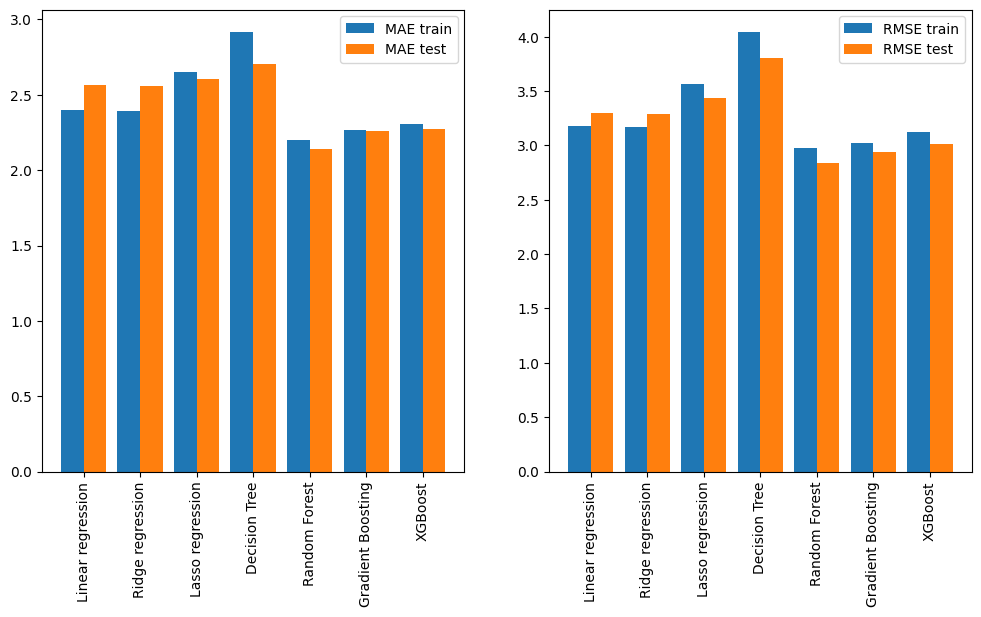

In [1167]:
fig,axes = plt.subplots(1,2,figsize=(12,6))
x_axis = x_axis = np.arange(errors_df.shape[0])
axes[0].bar(x_axis -0.2,  errors_df['MAE train'], width=0.4, label = 'MAE train')
axes[0].bar(x_axis +0.2, errors_df['MAE test'], width=0.4, label = 'MAE test')
axes[0].set_xticks(x_axis, errors_df['Model'],rotation=90)
axes[0].legend()

axes[1].bar(x_axis -0.2,  errors_df['RMSE train'], width=0.4, label = 'RMSE train')
axes[1].bar(x_axis +0.2, errors_df['RMSE test'], width=0.4, label = 'RMSE test')
axes[1].set_xticks(x_axis, errors_df['Model'],rotation=90)
axes[1].legend()

plt.show()

Decision tree model gives the worst results in term of mean absolute error and root mean squared error followed by Lasso. Linear regression and ridge regression give similar results, the regularization introduced in ridge  has minor effect in prediction. The top best 3 models are Random Forest, gradient Boosting and extreme gradient boosting. In the next section, we will tune the hypermarameter for these 3 models

# Hyperparameter Tuning
We will use Grid Search to fetch for the best parameters for each of the 3 models, fit the best estimators and assess their performance. 



In [1258]:
errors_ = []

## Hyperparameter Tuning for Random Forest
### Fitting the model and assessing performance

In [1195]:
RF_model =  RandomForestRegressor(random_state=47) 
    
grid_params = {
        'n_estimators': [10, 30, 50, 80, 100, 130, 160],
        'criterion' : ['absolute_error', 'squared_error'],
        'max_depth': [3, 5, 10, 20, None],
        'max_features' : [None, 'sqrt', 'log2']
        
}
rf_grid_cv = GridSearchCV(RF_model, param_grid=grid_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
rf_grid_cv.fit(X_train, y_train)
rf_grid_cv.best_params_

{'criterion': 'absolute_error',
 'max_depth': None,
 'max_features': None,
 'n_estimators': 130}

In [1260]:
best_model_RF = rf_grid_cv.best_estimator_
rf_best_cv_results = cross_validate(best_model_RF, X_train, y_train, cv=5,scoring=['neg_mean_absolute_error', 'neg_root_mean_squared_error'])

y_pred = best_model_RF.predict(X_test)

rf_mae_mean_train = -rf_best_cv_results['test_neg_mean_absolute_error'].mean()
rf_rmse_mean_train = -rf_best_cv_results['test_neg_root_mean_squared_error'].mean()

rf_mae_std_train = rf_best_cv_results['test_neg_mean_absolute_error'].std()
rf_rmse_std_train = rf_best_cv_results['test_neg_root_mean_squared_error'].std()

rf_mae_test = mae(y_test,y_pred )
rf_rmse_test =  np.sqrt(mse(y_test, y_pred)) 

errors_.append({'Model':'Random Forest',
               'Mean MAE train': rf_mae_mean_train,
               'Std MAE train mean' : rf_mae_std_train,
               'MAE test':rf_mae_test,
               'Mean RMSE train':rf_rmse_mean_train,
               'Std RMSE train':rf_rmse_std_train,
               'RMSE test':rf_rmse_test})

### Feature importances of the best random forest regressor 

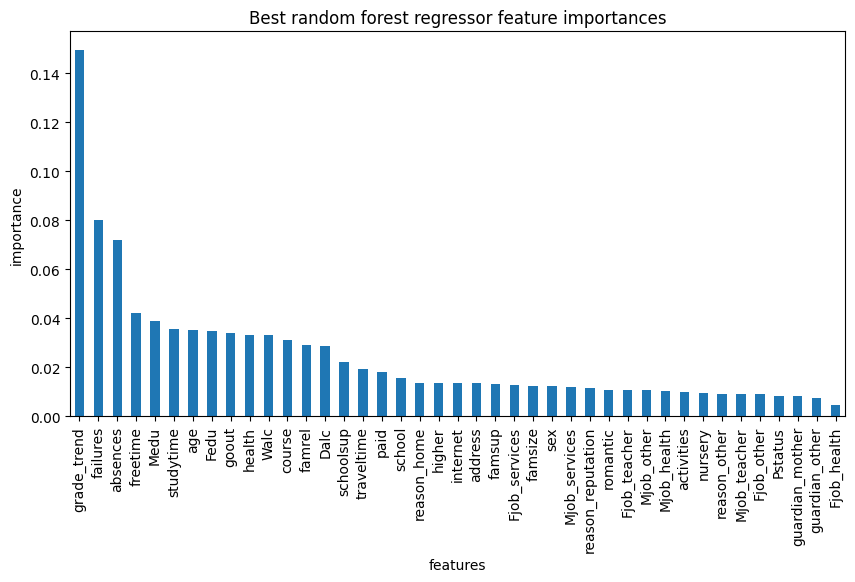

In [1215]:
plt.subplots(figsize=(10, 5))
imps = best_model_RF.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');

For Random Forest, the 5 most important features are grade_trend which represent the difference between the first and the second year of study, number of failures, number of absences, freetime and mother education>

## Hyperparameter Tuning for Gradien Boosting
### Fitting the model and assessing performance

In [1217]:
GB_model =  GradientBoostingRegressor(random_state=42) 
    
grid_params = {
    'learning_rate': np.arange(0.05, 1, 0.05),
    'max_depth': np.arange(3, 10, 1),
    'n_estimators': np.arange(50, 200, 50),
    'max_features': [None, 'sqrt', 'log2']
    
}
GB_grid_cv = GridSearchCV(GB_model, param_grid=grid_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
GB_grid_cv.fit(X_train, y_train)
GB_grid_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 5,
 'max_features': 'log2',
 'n_estimators': 100}

In [1262]:
best_model_GB = GB_grid_cv.best_estimator_
GB_best_cv_results = cross_validate(best_model_GB, X_train, y_train, cv=5,scoring=['neg_mean_absolute_error', 'neg_root_mean_squared_error'])

y_pred = best_model_GB.predict(X_test)

GB_mae_mean_train = -GB_best_cv_results['test_neg_mean_absolute_error'].mean()
GB_rmse_mean_train = -GB_best_cv_results['test_neg_root_mean_squared_error'].mean()

GB_mae_std_train = GB_best_cv_results['test_neg_mean_absolute_error'].std()
GB_rmse_std_train = GB_best_cv_results['test_neg_root_mean_squared_error'].std()

GB_mae_test = mae(y_test,y_pred )
GB_rmse_test =  np.sqrt(mse(y_test, y_pred)) 

errors_.append({'Model':'Gradient Boosting',
               'Mean MAE train': GB_mae_mean_train,
               'Std MAE train mean' : GB_mae_std_train,
               'MAE test':GB_mae_test,
               'Mean RMSE train':GB_rmse_mean_train,
               'Std RMSE train':GB_rmse_std_train,
               'RMSE test':GB_rmse_test})

### Feature importances of the best Gradient boosting regressor 

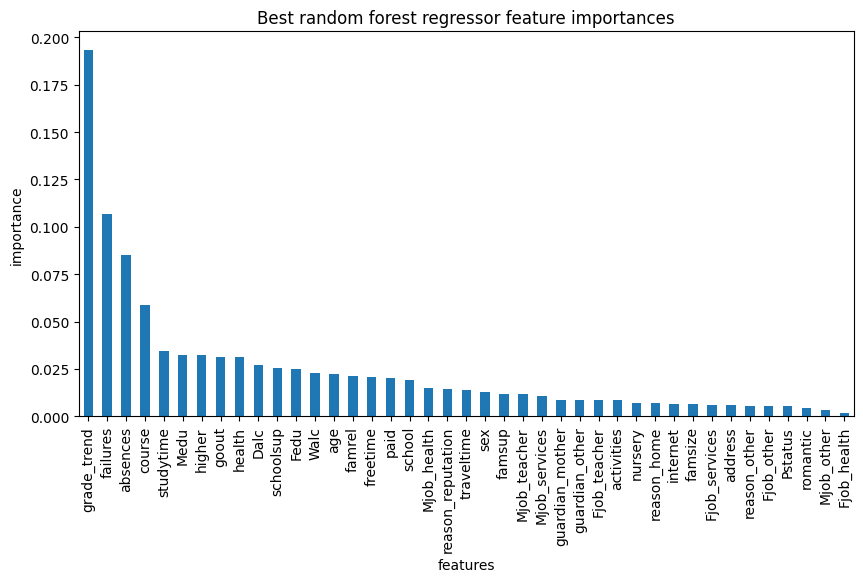

In [1227]:
plt.subplots(figsize=(10, 5))
imps = best_model_GB.feature_importances_
GB_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
GB_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');

In the 5 most imortant features for the Gradient Boosting, there are 3 common features with the Random Forest model which are *grade_trend*, *failures* and *absences*. This model emphasizes two other features namely *course* and *studytime*. Mother education is not far from this later feature (they have close weights)

## Hyperparameter Tuning for Extreme Gradien Boosting
### Fitting the model and assessing performance

In [1229]:
XGB_model =  XGBRegressor(objective= 'reg:squarederror')
    
grid_params = {
    'learning_rate': np.arange(0.05, 1, 0.05),
    'max_depth': np.arange(3, 10, 1),
    'n_estimators': np.arange(50, 200, 50),
    'max_features': [None, 'sqrt', 'log2'],
    'alpha': [0, 0.1, 1, 10],
    'lambda': [0, 0.1, 1, 10]
}
XGB_grid_cv = GridSearchCV(XGB_model, param_grid=grid_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
XGB_grid_cv.fit(X_train, y_train)
XGB_grid_cv.best_params_

{'alpha': 10,
 'lambda': 0,
 'learning_rate': 0.1,
 'max_depth': 6,
 'max_features': None,
 'n_estimators': 150}

In [1264]:
best_model_XGB = XGB_grid_cv.best_estimator_
XGB_best_cv_results = cross_validate(best_model_XGB, X_train, y_train, cv=5,scoring=['neg_mean_absolute_error', 'neg_root_mean_squared_error'])

y_pred = best_model_XGB.predict(X_test)

XGB_mae_mean_train = -XGB_best_cv_results['test_neg_mean_absolute_error'].mean()
XGB_rmse_mean_train = -XGB_best_cv_results['test_neg_root_mean_squared_error'].mean()

XGB_mae_std_train = XGB_best_cv_results['test_neg_mean_absolute_error'].std()
XGB_rmse_std_train = XGB_best_cv_results['test_neg_root_mean_squared_error'].std()

XGB_mae_test = mae(y_test,y_pred )
XGB_rmse_test =  np.sqrt(mse(y_test, y_pred)) 

errors_.append({'Model':'Extreme Gradient Boosting',
               'Mean MAE train': XGB_mae_mean_train,
               'Std MAE train mean' : XGB_mae_std_train,
               'MAE test':XGB_mae_test,
               'Mean RMSE train':XGB_rmse_mean_train,
               'Std RMSE train':XGB_rmse_std_train,
               'RMSE test':XGB_rmse_test})

### Feature importances of the best Extreme Gradient boosting regressor 

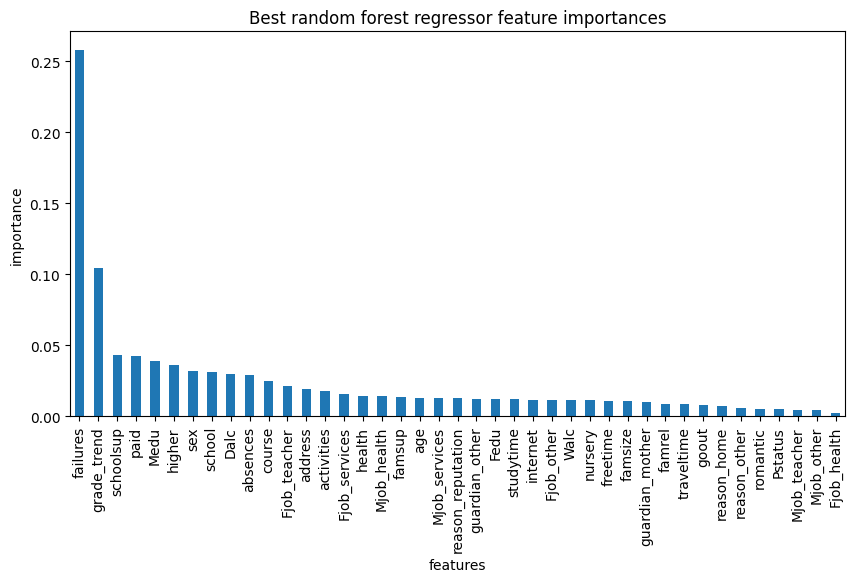

In [1233]:
plt.subplots(figsize=(10, 5))
imps = best_model_XGB.feature_importances_
XGB_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
XGB_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');

Similar to Random Forest and Gradient Boosting, XGBoost has the number of failures and the student grade history as the two most important features. It has also the mother education among its top 5 important features like Random Forest. This model emphasizes two other features namely *schoolsup* and *paid* with very close weights.

# Model selection

In [1266]:
errors_df_best = pd.DataFrame(errors_)
errors_df_best

,Model,Mean MAE train,Std MAE train mean,MAE test,Mean RMSE train,Std RMSE train,RMSE test
0,Random Forest,2.195472,0.119342,2.181856,2.980346,0.175939,2.865817
1,Gradient Boosting,2.215259,0.134050,2.217440,2.942526,0.178106,2.891902
2,Extreme Gradient Boosting,2.171998,0.173510,2.200703,2.907303,0.228338,2.851172


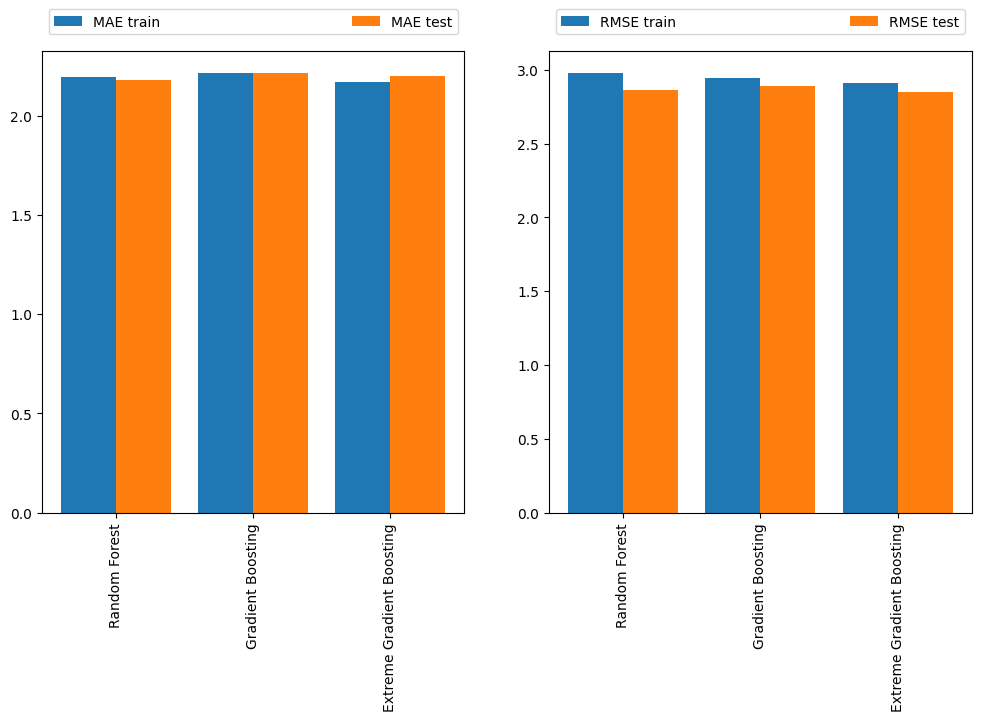

In [1268]:
fig,axes = plt.subplots(1,2,figsize=(12,6))
x_axis = x_axis = np.arange(errors_df_best.shape[0])
axes[0].bar(x_axis -0.2,  errors_df_best['Mean MAE train'], width=0.4, label = 'MAE train')
axes[0].bar(x_axis +0.2, errors_df_best['MAE test'], width=0.4, label = 'MAE test')
axes[0].set_xticks(x_axis, errors_df_best['Model'],rotation=90)
axes[0].legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",mode='expand', ncol=2)

axes[1].bar(x_axis -0.2,  errors_df_best['Mean RMSE train'], width=0.4, label = 'RMSE train')
axes[1].bar(x_axis +0.2, errors_df_best['RMSE test'], width=0.4, label = 'RMSE test')
axes[1].set_xticks(x_axis, errors_df_best['Model'],rotation=90)
axes[1].legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",mode='expand', ncol=2)

plt.show()

The train error and the test error are close for the considered models indicating that we avoided overfitting of these models. The model giving the least test MAE is the Random forest. XGBoost allows a slight better test RMSE.

# Conclusion

In order to predict the G3 grade, we have considered & regression models:

1. Linear regression
2. Ridge regression
3. Lasso regression
4. Decision Tree
5. Random Forest
6. gradient boost regressor
7. XGBoost regressor

   
After splitting the dataset into train and validation set, we scaled the data, this scaled data is used only for the linear, ridge and lasso regression. Tree based models are trained on non scaled data (these models are not distance based algorithms). 

We have evaluated each models in terms of mean absolute error (MAE) and root mean squared error (RMSE) for both the training and test data. The three best performing models are the Random forest, Gradient boost and Extreme gradient boost.

Next, we have applied the grid search CV for the hyperparameter tuning for the top three models seperately and we have assessed their performance. This step is very time consuming due to the use of grid search, this could be improved by the use of random search.

The three models have very close results, Random Forest slightly outperforms the other two models in terms of MAE wheras XGBOOST has a better RMSE.



***********************************************************************************************************************